# P1. Classification Animals-10

Task: load the Animals-10, write a simple neural network to perform classification over most frequent face classes, test the network and plot the results for each class.

<!-- ![Animals-10](https://storage.googleapis.com/kaggle-datasets-images/59760/115796/95649e825d9344084af2a24012c4d072/dataset-cover.jpg?t=2018-10-05-08-07-40) -->

## Task 0: Import libraries ✅

All the libraries in this section should be enough for the project. If you want to, you can import more libraries.

In [1]:
# We need to first install PyTorch Lightning, since it's not included in Python
%pip install pytorch-lightning torchvision


[notice] A new release of pip is available: 25.0 -> 25.0.1
[notice] To update, run: pip install --upgrade pip
Note: you may need to restart the kernel to use updated packages.


In [2]:
# Matplotlib for plotting, numpy for math operations
from matplotlib import pyplot as plt
import numpy as np

# PyTorch Lightning ⚡ to define our neural network
import torch
import torch.nn as nn
from torch.nn import functional as F
import pytorch_lightning as pl
from pytorch_lightning import LightningModule, Trainer

# Dataloader and torchvision to define our input dataset
from torch.utils.data import random_split, DataLoader
from torchvision.datasets import ImageFolder
from torchvision import transforms

# Torchmetrics to monitor metrics (classification accuracy)
from torchmetrics.functional.classification.accuracy import accuracy

## Task 1: Download/Import Dataset 📃
Link full dataset: https://www.kaggle.com/datasets/alessiocorrado99/animals10

Link tiny version: https://drive.google.com/file/d/1mJWlU-jHWYZPonFHF5Kmdhhb6OfJmnD5/view?usp=sharing

In [3]:
import os
# Make sure to upload the data in colab
# Importing our dataset

## Task 1: Define parameters and hyperparameters 📃


*   **Learning rate** - how fast does our network learn? (Warning, do not set too high)
*   **Batch size** - how many samples does the network "see" at every iteration (usually, the bigger the better)
*   **Dataset size** - how many samples are in the whole dataset? (train + validation)
*   **Train size** - how many samples are in the training dataset?
*   **Val size** - how many samples are in the validation dataset?
*   **Input width** - how wide (in pixels) is our input image? (must be square images)
*   **Input height** - how tall (in pixels) is our input image? (must be square images)
*   **Input channels** - how many channels does the input image have?
*   **Mean** - dataset mean
*   **Std** - dataset standard variance
*   **Hidden dim** - how many neurons are there in the hidden layer?
*   **Num classes** - how many classes (digits) do we want to classify in our dataset?





In [4]:
input_width = 224
input_height = 224
input_channels = 3

train_percentage = 0.7
val_percentage = 0.1
test_percentage = 0.2

In [5]:
SEED = 42
np.random.seed(SEED)
torch.manual_seed(SEED)
if torch.cuda.is_available():
  torch.cuda.manual_seed_all(SEED)
if torch.backends.cudnn.enabled:
  torch.backends.cudnn.deterministic = True
  torch.backends.cudnn.benchmark = False

In [6]:
# Load the dataset

batch_size = 32
# Manual Transform the dataset to crop the images to the same size
manual_transform = transforms.Compose([
  transforms.Resize((input_width, input_height)),
  transforms.ToTensor()
])

dataset = ImageFolder(root='animals10/raw-img', transform=manual_transform) #set correct path
loader = DataLoader(dataset, batch_size=batch_size, shuffle=False, num_workers=2)


In [ ]:
learning_rate = 0.0001

dataset_size = len(dataset)

# Compute mean and standard deviation for each channel
mean = torch.zeros(3)
std = torch.zeros(3)

for images, _ in loader:
  for i in range(input_channels):
    mean[i] += images[:, i, :, :].mean()
    std[i] += images[:, i, :, :].std()

mean /= len(loader)
std /= len(loader)

print(f'Mean: {mean}')
print(f'Std: {std}')

hidden_dim = 64
num_classes = 10

assert input_width == input_height, "Oh no! The input width should be the same as the input height!"

Mean: tensor([0.5126, 0.4952, 0.4027])
Std: tensor([0.2649, 0.2580, 0.2753])


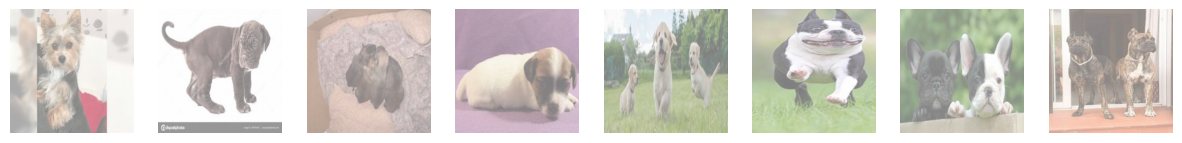

In [8]:
# Get some random training images
dataiter = iter(loader)
images, labels = next(dataiter)
# Use a subset of the images to speed up plotting
images = images[:8]

# Plot the images in a single plot
fig, axes = plt.subplots(1, len(images), figsize=(15, 15))
for idx, img in enumerate(images):
  img = img / 2 + 0.5  # unnormalize
  npimg = img.numpy()
  axes[idx].imshow(np.transpose(npimg, (1, 2, 0)))
  axes[idx].axis('off')
plt.show()

## Task 2: Define the DataModule 📃
Download the LFW dataset filter the most frequent classes and prepare the train/val/test splits

🌟 **HINT** 🌟
Filtering of the data can be done in the setup function of the Datamodule

In [9]:
class MyCustomDataModule(pl.LightningDataModule):
    def __init__(self, data_dir: str = "./"):
        super().__init__()
        self.data_dir = data_dir
        self.transform = transforms.Compose([transforms.ToTensor(), transforms.Normalize(mean, std)])

    def prepare_data(self):
        pass

    def setup(self, stage = None):
        # Split dataset into train, validation, and test sets
        # Ensure uniform split for each class
        targets = np.array([s[1] for s in dataset.samples])
        train_indices, val_indices, test_indices = [], [], []

        for class_idx in range(num_classes):
            class_indices = np.where(targets == class_idx)[0]
            np.random.shuffle(class_indices)
            train_end = int(train_percentage * len(class_indices))
            val_end = int(val_percentage * len(class_indices)) + train_end

            train_indices.extend(class_indices[:train_end])
            val_indices.extend(class_indices[train_end:val_end])
            test_indices.extend(class_indices[val_end:])

        self.dataset_train = torch.utils.data.Subset(dataset, train_indices)
        self.dataset_val = torch.utils.data.Subset(dataset, val_indices)
        self.dataset_test = torch.utils.data.Subset(dataset, test_indices)

    def train_dataloader(self):
        return DataLoader(self.dataset_train, batch_size=batch_size)

    def val_dataloader(self):
        return DataLoader(self.dataset_val, batch_size=batch_size)

    def test_dataloader(self):
        return DataLoader(self.dataset_test, batch_size=batch_size)

## Task 3: Define the neural network 📃


In [10]:
class MyCustomModel(LightningModule):
    def __init__(self):
        super().__init__()

        self.ground_truth = []
        self.predictions = []

        self.model = nn.Sequential(
            nn.Flatten(),
            nn.Linear(input_channels * input_width * input_height, hidden_dim),
            nn.ReLU(),
            nn.Dropout(0.1),
            nn.Linear(hidden_dim, hidden_dim),
            nn.ReLU(),
            nn.Dropout(0.1),
            nn.Linear(hidden_dim, num_classes),
        )

    def forward(self, x):
        x = self.model(x)
        return x

    def training_step(self, batch, batch_nb):
        x, y = batch
        x = self(x)
        loss = F.cross_entropy(x, y)

        preds = torch.argmax(x, dim=1)
        acc = accuracy(preds, y, task='multiclass',num_classes=len(y))

        self.log("train_loss", loss, prog_bar=True)
        self.log("train_acc", acc, prog_bar=True)
        return loss

    def validation_step(self, batch, batch_nb):
        x, y = batch
        x = self(x)
        loss = F.cross_entropy(x, y)
        return loss

    def test_step(self, batch, batch_nb):
        x, y = batch
        x = self(x)
        loss = F.cross_entropy(x, y)

        preds = torch.argmax(x, dim=1)
        acc = accuracy(preds, y, task='multiclass', num_classes=len(y))

        self.ground_truth.append(y.data)     # Save ground truth
        self.predictions.append(preds.data)       # Save predictions

        # Calling self.log will surface up scalars for you in TensorBoard
        self.log("val_loss", loss, prog_bar=True)
        self.log("val_acc", acc, prog_bar=True)

        return loss

    def configure_optimizers(self):
        return torch.optim.Adam(self.parameters(), lr=learning_rate)

## Task 4: Train 📃

In [ ]:
# Init our model
model = MyCustomModel()

# Init DataModule
datamodule = MyCustomDataModule()


# Initialize a trainer
trainer = Trainer(
    max_epochs= 100
)

%set_env PYTORCH_MPS_HIGH_WATERMARK_RATIO=0.0

# Train the model
trainer.fit(model, datamodule)

GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
/Users/salvatore/Library/Python/3.13/lib/python/site-packages/pytorch_lightning/trainer/connectors/logger_connector/logger_connector.py:76: Starting from v1.9.0, `tensorboardX` has been removed as a dependency of the `pytorch_lightning` package, due to potential conflicts with other packages in the ML ecosystem. For this reason, `logger=True` will use `CSVLogger` as the default logger, unless the `tensorboard` or `tensorboardX` packages are found. Please `pip install lightning[extra]` or one of them to enable TensorBoard support by default

  | Name  | Type       | Params | Mode 
---------------------------------------------
0 | model | Sequential | 9.6 M  | train
---------------------------------------------
9.6 M     Trainable params
0         Non-trainable params
9.6 M     Total params
38.555    Total estimated model params size (MB)
9         Modules in train mode
0   

env: PYTORCH_MPS_HIGH_WATERMARK_RATIO=0.0
                                                                           

/Users/salvatore/Library/Python/3.13/lib/python/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:425: The 'val_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=7` in the `DataLoader` to improve performance.
/Users/salvatore/Library/Python/3.13/lib/python/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:425: The 'train_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=7` in the `DataLoader` to improve performance.
/Users/salvatore/Library/Python/3.13/lib/python/site-packages/pytorch_lightning/loops/fit_loop.py:310: The number of training batches (22) is smaller than the logging interval Trainer(log_every_n_steps=50). Set a lower value for log_every_n_steps if you want to see logs for the training epoch.


Epoch 49: 100%|██████████| 22/22 [00:02<00:00,  9.34it/s, v_num=15, train_loss=2.290, train_acc=0.000] 

`Trainer.fit` stopped: `max_epochs=50` reached.


Epoch 49: 100%|██████████| 22/22 [00:02<00:00,  8.93it/s, v_num=15, train_loss=2.290, train_acc=0.000]


## Task 5: Test ✅

In [12]:
trainer.test(datamodule=datamodule)

/Users/salvatore/Library/Python/3.13/lib/python/site-packages/pytorch_lightning/trainer/connectors/checkpoint_connector.py:145: `.test(ckpt_path=None)` was called without a model. The best model of the previous `fit` call will be used. You can pass `.test(ckpt_path='best')` to use the best model or `.test(ckpt_path='last')` to use the last model. If you pass a value, this warning will be silenced.
Restoring states from the checkpoint path at /Users/salvatore/Desktop/Uni/Vision and recognition/lightning_logs/version_15/checkpoints/epoch=49-step=1100.ckpt
Loaded model weights from the checkpoint at /Users/salvatore/Desktop/Uni/Vision and recognition/lightning_logs/version_15/checkpoints/epoch=49-step=1100.ckpt
/Users/salvatore/Library/Python/3.13/lib/python/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:425: The 'test_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=7` in t

Testing DataLoader 0: 100%|██████████| 7/7 [00:00<00:00, 14.16it/s]
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
         val_acc            0.10499999672174454
        val_loss             2.301896333694458
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────


[{'val_loss': 2.301896333694458, 'val_acc': 0.10499999672174454}]

## Task 6: Show results and experiment with splits 📃

In [13]:
print("Ground truth length: ", len(model.ground_truth))
print("Predictions length: ", len(model.predictions))

print("Ground truth sample: ", model.ground_truth[0][:10])
print("Predictions sample: ", model.predictions[0][:10])

Ground truth length:  7
Predictions length:  7
Ground truth sample:  tensor([0, 0, 0, 0, 0, 0, 0, 0, 0, 0], device='mps:0')
Predictions sample:  tensor([5, 5, 5, 5, 5, 5, 5, 5, 5, 5], device='mps:0')


In [14]:
correct = [0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
wrong = [0, 0, 0, 0, 0, 0, 0, 0, 0, 0]

for i, (batch_gt, batch_pred) in enumerate(zip(model.ground_truth, model.predictions)):
  for gt, pred in zip(batch_gt, batch_pred):
    if gt == pred:
      correct[gt] += 1
    else:
      wrong[gt] += 1

print(correct)
print(wrong)

[0, 0, 0, 0, 0, 20, 0, 0, 1, 0]
[20, 20, 20, 20, 20, 0, 20, 20, 19, 20]


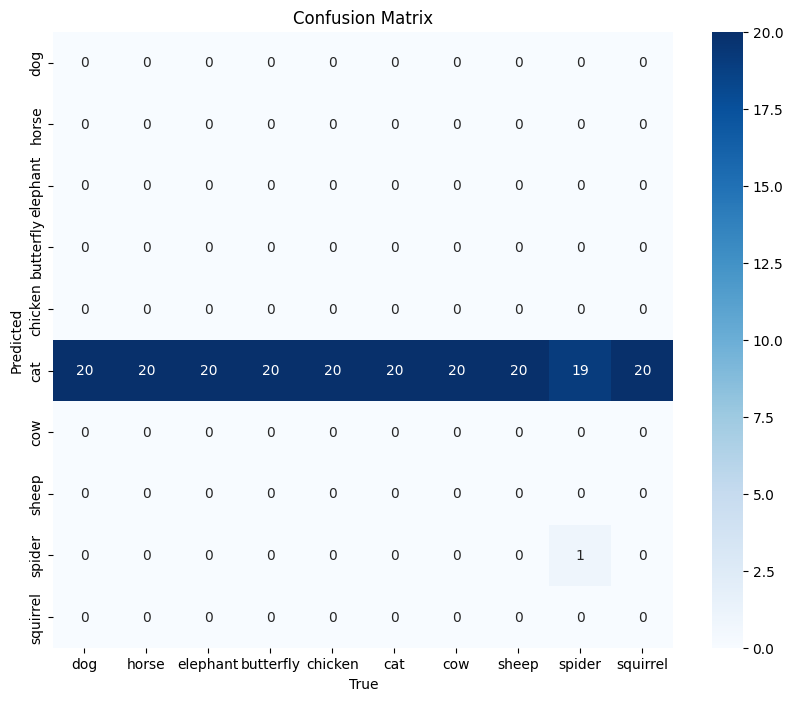

In [15]:
from sklearn.metrics import confusion_matrix
import seaborn as sns

# Assuming class_labels contains the animal names
animal_names = ['dog', 'horse', 'elephant', 'butterfly', 'chicken', 'cat', 'cow', 'sheep', 'spider', 'squirrel']

# Flatten the ground truth and predictions
ground_truth_flat = torch.cat(model.ground_truth).cpu().numpy()
predictions_flat = torch.cat(model.predictions).cpu().numpy()

# Compute the confusion matrix
cm = confusion_matrix(predictions_flat, ground_truth_flat)

# Plot the confusion matrix
plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt='d', xticklabels=animal_names, yticklabels=animal_names, cmap='Blues')
plt.xlabel('True')
plt.ylabel('Predicted')
plt.title('Confusion Matrix')
plt.show()

### Validate model